In [1]:
import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# First Time to Run
def get_mean_std(train_data):
    '''
    Compute mean and variance for training data
    :param train_data: Custom Dataset(或 ImageFolder 即可)
    :return: (mean, std)
    '''
    print('Compute mean and variance for training data.')
    print(len(train_data))
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=1, shuffle=False, num_workers=0,
        pin_memory=True)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for X, _ in train_loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()), list(std.numpy())

In [3]:
# Transform
# TODO: image transform
# 1. Resizing
# 2. Normalization
# 3. Data Augmentation
# 4. Noise Reduction
# 5. Color Space Conversion

mean, std = [0.51788974, 0.4103852, 0.3304464], [0.26347664, 0.2106541, 0.22013563]
# mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
)

augment_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.RandomRotation(10),       # Randomly rotate by up to 10 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
        transforms.RandomGrayscale(p=0.2),  # Convert to grayscale with 20% probability
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean, std)  # Normalize using ImageNet statistics
    ]
)

## Data Process
* statics of data
    ```
    Output:
    train size: 1020 (12%)
    valid size: 1020 (12%)
    test size: 6149  (75%)
    batch img: torch.Size([64, 3, 224, 224]), label: torch.Size([64])
    ```
* So I use test data as training data
* I also concate the data and augmented data together to make it twice larger

In [4]:
# Dataset
train = torchvision.datasets.Flowers102(root='./data', split='test',
                                        download=True, transform=transform)

augment = torchvision.datasets.Flowers102(root='./data', split='test',
                                        download=True, transform=augment_transform)

valid_set = torchvision.datasets.Flowers102(root='./data', split='val',
                                        download=True, transform=transform)

test_set = torchvision.datasets.Flowers102(root='./data', split='train',
                                        download=True, transform=transform)

train_set = torch.utils.data.ConcatDataset([train, augment])

In [5]:
# Bach size
batch_size = 64

# Classes
classes = np.arange(1, 103).astype(str)

# DataLoader
# My CPU core: 6, threads per core: 2 
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                          shuffle=True, num_workers=4, pin_memory=True)

validloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

## Image Display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


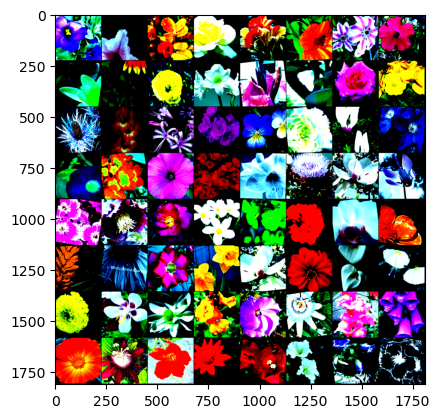

In [6]:
def imshow(img):
    img_array = img.numpy()
    plt.imshow(np.transpose(img_array, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Model
* Try three activation function
* ReLU, Leaky ReLU, SiLU

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# TODO: Try three activation function
class ResBlock(nn.Module):
    
    def __init__(self, input_dim, block_dim, stride=1, activation=nn.ReLU(inplace=True)):
        super(ResBlock, self).__init__()
        self.input_dim = input_dim
        self.output_dim = block_dim*4
        self.stride = stride
        self.activation = nn.Sequential(activation)
        
        # input_dim -> block_dim -> block_dim -> 4 * block_dim
        # stride = 1: hieght & width no change
        # stride = 2: H/2, W/2
        self.block = nn.Sequential(
            nn.Conv2d(input_dim,block_dim,1,stride=self.stride,bias=False),
            nn.BatchNorm2d(block_dim),
            activation,
            nn.Conv2d(block_dim,block_dim,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(block_dim),
            activation,
            nn.Conv2d(block_dim,self.output_dim,1,stride=1,bias=False),
            nn.BatchNorm2d(self.output_dim)
        )
        # downsample: use for matching the dimension of filter
        self.downsample = nn.Sequential(
            nn.Conv2d(input_dim, self.output_dim,1,stride=self.stride,bias=False),
            nn.BatchNorm2d(self.output_dim)
        )
        
    def forward(self, x):
        tmp = self.block(x)
        if self.stride != 1 or self.input_dim != self.output_dim:
            res = self.downsample(x)
        else:
            res = x
        tmp = tmp + res
        return self.activation(tmp)

In [8]:
class ResNet50(nn.Module):
    
    def __init__(self, n_class, activation=nn.ReLU(inplace=True)):
        super(ResNet50, self).__init__()
        self.foot = nn.Sequential(  # [H,W]: 224 -> 112 -> 56
            nn.Conv2d(3,64,7,stride=2, padding = 3, bias=False),
            nn.BatchNorm2d(64),
            activation,
            nn.MaxPool2d(3,stride=2, padding=1)
        )
        self.block1 = nn.Sequential(# [H,W]: 56 -> 56
            ResBlock(64,64,1, activation),      # 64 -> 256, block=64, output=256
            ResBlock(256,64,1, activation),     # 256 -> 256, block=64, output=256
            ResBlock(256,64,1, activation)      # 256 -> 256, block=64, output=256
        )
        self.block2 = nn.Sequential(# [H,W]: 56 -> 28
            ResBlock(256,128,2, activation),    # 256 -> 512, block=128, output=512 (downsample)
            ResBlock(512,128,1, activation),    # 512 -> 512, block=128, output=512
            ResBlock(512,128,1, activation),    # 512 -> 512, block=128, output=512
            ResBlock(512,128,1, activation)     # 512 -> 512, block=128, output=512
        )
        self.block3 = nn.Sequential(# [H,W]: 28 -> 14
            ResBlock(512,256,2, activation),    # 512 -> 1024, block=256, output=1024 (downsample)
            ResBlock(1024,256,1, activation),   # 512 -> 1024, block=256, output=1024
            ResBlock(1024,256,1, activation),   # 512 -> 1024, block=256, output=1024
            ResBlock(1024,256,1, activation),   # 512 -> 1024, block=256, output=1024
            ResBlock(1024,256,1, activation),   # 512 -> 1024, block=256, output=1024
            ResBlock(1024,256,1, activation)    # 512 -> 1024, block=256, output=1024
        )
        self.block4 = nn.Sequential(# [H,W]: 14 -> 7
            ResBlock(1024,512,2, activation),   # 1024 -> 2048, block=512, output=2048 (downsample)
            ResBlock(2048,512,1, activation),   # 2048 -> 2048, block=512, output=2048
            ResBlock(2048,512,1, activation),   # 2048 -> 2048, block=512, output=2048
            nn.AdaptiveAvgPool2d((1,1))# [H,W]: 7 -> 1, output_size(1, 1)
        )
        self.fc = nn.Sequential(
            nn.Linear(2048, n_class)
        )

        
    def forward(self, x):
        x = self.foot(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Example Code Model

In [9]:
# code from example classifier
class ExampleNet(nn.Module):
    def __init__(self, n_class):
        super(ExampleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)           # Add new conv3
        self.fc1 = nn.Linear(32 * 25 * 25, 1024)     # modify 120->1024
        self.fc2 = nn.Linear(1024, 512)              # modify 84->512
        self.fc3 = nn.Linear(512, n_class)          # 512->102
        # you can try other module like dropout, batch normalization, etc to improve model.
        # And other activation function like sigmoid, tanh, etc.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 224 -> 220 -> 110
        x = self.pool(F.relu(self.conv2(x))) # 110 -> 106-> 53
        x = self.pool(F.relu(self.conv3(x))) # 53 -> 51 -> 25
        x = x.view(-1, 32 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Configuration

In [71]:
# "cuda" on GPU
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)

# train experiment name
# TODO: load model need modify
checkpoint_name = 'NAdam_example'
model_name = 'example'

# tensorboard 
writer = SummaryWriter(log_dir='./log', filename_suffix=checkpoint_name)

# model configuration
device = torch.device(device)

# if no improvement in patience epochs, early stop
patience = 15

# number of training epochs
n_epochs = 200

# learning rate
LR = 0.001

# TODO: L2 punishment
L2_weight = 1e-4

# model: compare with different optimizer
net_NAdam = ResNet50(102, nn.ReLU()).to(device)
net_example = ExampleNet(102)

net = net_example.to(device)

# measureent of performacne
criterion = nn.CrossEntropyLoss()

# optimizer with some hyperparameters
opt_NAdam = torch.optim.NAdam(net_example.parameters(), lr=LR, weight_decay=L2_weight)
optimizer = opt_NAdam

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

# TODO Load my pre-train model
# load_type = 'last'
# load_checkpoint_name = 'Adam_schedule'
# checkpoint = torch.load(f"{load_checkpoint_name}_{load_type}.ckpt")
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# epoch_start = checkpoint['epoch']
# n_epochs += epoch_start

[INFO] Current device: NVIDIA GeForce RTX 3080 , device num:0


In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Train & Valid

In [19]:
stale = 0
best_acc = 0

for epoch in range(n_epochs):
    # ---------- Training ----------
    net.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(trainloader):
        imgs, labels = batch[0].to(device), batch[1].to(device)
        outputs = net(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        # Clip the gradient norms for stable training.
        # grad_norm = nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)

        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (outputs.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    net.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    for batch in tqdm(validloader):
        imgs, labels = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            outputs = net(imgs)

        loss = criterion(outputs, labels)

        # Compute the accuracy for current batch.
        acc = (outputs.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # learning rate scheduler
    scheduler.step(valid_loss)

    # tensorboard writer
    writer.add_scalars('Accuracy', {f'Train/{model_name}': train_acc,
                                    f'Valid/{model_name}': valid_acc}, epoch)
    writer.add_scalars('Loss', {f'Train/{model_name}': train_loss,
                                f'Valid/{model_name}': valid_loss}, epoch)
    writer.flush()

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{checkpoint_name}_log.txt","a") as f:
            f.write(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best\n")
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{checkpoint_name}_log.txt","a") as f:
            f.write(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}\n")


    # save nets
    if valid_acc > best_acc:
        print('learning rate:', get_lr(optimizer))
        print(f"Best net found at epoch {epoch}, saving net")
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            }, f"{checkpoint_name}_best.ckpt")
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

# save last net
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            }, f"{checkpoint_name}_last.ckpt")       
writer.close()

100%|██████████| 193/193 [00:58<00:00,  3.31it/s]


[ Train | 001/200 ] loss = 3.93460, acc = 0.10183


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


[ Valid | 001/200 ] loss = 4.31168, acc = 0.06276
[ Valid | 001/200 ] loss = 4.31168, acc = 0.06276 -> best
learning rate: 0.001
Best net found at epoch 0, saving net


100%|██████████| 193/193 [00:50<00:00,  3.81it/s]


[ Train | 002/200 ] loss = 3.41622, acc = 0.17719


100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


[ Valid | 002/200 ] loss = 3.55662, acc = 0.16387
[ Valid | 002/200 ] loss = 3.55662, acc = 0.16387 -> best
learning rate: 0.001
Best net found at epoch 1, saving net


100%|██████████| 193/193 [00:48<00:00,  3.99it/s]


[ Train | 003/200 ] loss = 3.04564, acc = 0.25335


100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


[ Valid | 003/200 ] loss = 3.42797, acc = 0.19206
[ Valid | 003/200 ] loss = 3.42797, acc = 0.19206 -> best
learning rate: 0.001
Best net found at epoch 2, saving net


100%|██████████| 193/193 [00:49<00:00,  3.92it/s]


[ Train | 004/200 ] loss = 2.71218, acc = 0.33104


100%|██████████| 16/16 [00:05<00:00,  2.76it/s]


[ Valid | 004/200 ] loss = 3.08780, acc = 0.27259
[ Valid | 004/200 ] loss = 3.08780, acc = 0.27259 -> best
learning rate: 0.001
Best net found at epoch 3, saving net


100%|██████████| 193/193 [00:48<00:00,  3.96it/s]


[ Train | 005/200 ] loss = 2.39260, acc = 0.40416


100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


[ Valid | 005/200 ] loss = 2.84795, acc = 0.30684
[ Valid | 005/200 ] loss = 2.84795, acc = 0.30684 -> best
learning rate: 0.001
Best net found at epoch 4, saving net


100%|██████████| 193/193 [00:50<00:00,  3.82it/s]


[ Train | 006/200 ] loss = 2.16387, acc = 0.47338


100%|██████████| 16/16 [00:05<00:00,  3.07it/s]


[ Valid | 006/200 ] loss = 3.91601, acc = 0.23620


100%|██████████| 193/193 [00:49<00:00,  3.92it/s]


[ Train | 007/200 ] loss = 1.96910, acc = 0.52267


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


[ Valid | 007/200 ] loss = 2.92863, acc = 0.35592
[ Valid | 007/200 ] loss = 2.92863, acc = 0.35592 -> best
learning rate: 0.001
Best net found at epoch 6, saving net


100%|██████████| 193/193 [00:50<00:00,  3.84it/s]


[ Train | 008/200 ] loss = 1.80783, acc = 0.56802


100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


[ Valid | 008/200 ] loss = 2.37536, acc = 0.43822
[ Valid | 008/200 ] loss = 2.37536, acc = 0.43822 -> best
learning rate: 0.001
Best net found at epoch 7, saving net


100%|██████████| 193/193 [00:48<00:00,  4.01it/s]


[ Train | 009/200 ] loss = 1.72503, acc = 0.59003


100%|██████████| 16/16 [00:05<00:00,  3.20it/s]


[ Valid | 009/200 ] loss = 2.91997, acc = 0.34323


100%|██████████| 193/193 [00:42<00:00,  4.51it/s]


[ Train | 010/200 ] loss = 1.67139, acc = 0.60732


100%|██████████| 16/16 [00:04<00:00,  3.26it/s]


[ Valid | 010/200 ] loss = 2.63950, acc = 0.42702


100%|██████████| 193/193 [00:43<00:00,  4.44it/s]


[ Train | 011/200 ] loss = 1.58703, acc = 0.62215


100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


[ Valid | 011/200 ] loss = 2.38234, acc = 0.43451


100%|██████████| 193/193 [00:43<00:00,  4.49it/s]


[ Train | 012/200 ] loss = 1.55077, acc = 0.63384


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


[ Valid | 012/200 ] loss = 2.39831, acc = 0.47259
[ Valid | 012/200 ] loss = 2.39831, acc = 0.47259 -> best
learning rate: 0.001
Best net found at epoch 11, saving net


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 013/200 ] loss = 1.54083, acc = 0.63467


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


[ Valid | 013/200 ] loss = 2.63812, acc = 0.39701


100%|██████████| 193/193 [00:41<00:00,  4.65it/s]


[ Train | 014/200 ] loss = 1.49892, acc = 0.64045


100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


[ Valid | 014/200 ] loss = 2.54717, acc = 0.43672


100%|██████████| 193/193 [00:41<00:00,  4.63it/s]


[ Train | 015/200 ] loss = 1.47929, acc = 0.64653


100%|██████████| 16/16 [00:04<00:00,  3.29it/s]


[ Valid | 015/200 ] loss = 2.56532, acc = 0.42839


100%|██████████| 193/193 [00:41<00:00,  4.65it/s]


[ Train | 016/200 ] loss = 1.45344, acc = 0.64874


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 016/200 ] loss = 2.27336, acc = 0.44277


100%|██████████| 193/193 [00:41<00:00,  4.67it/s]


[ Train | 017/200 ] loss = 1.44597, acc = 0.65599


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


[ Valid | 017/200 ] loss = 2.20673, acc = 0.45879


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 018/200 ] loss = 1.41591, acc = 0.65402


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


[ Valid | 018/200 ] loss = 2.60909, acc = 0.43333


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 019/200 ] loss = 1.42404, acc = 0.65572


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


[ Valid | 019/200 ] loss = 2.61991, acc = 0.41322


100%|██████████| 193/193 [00:42<00:00,  4.57it/s]


[ Train | 020/200 ] loss = 1.39463, acc = 0.66312


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


[ Valid | 020/200 ] loss = 2.36454, acc = 0.45117


100%|██████████| 193/193 [00:41<00:00,  4.65it/s]


[ Train | 021/200 ] loss = 1.38776, acc = 0.66341


100%|██████████| 16/16 [00:04<00:00,  3.28it/s]


[ Valid | 021/200 ] loss = 2.66741, acc = 0.41634


100%|██████████| 193/193 [00:41<00:00,  4.64it/s]


[ Train | 022/200 ] loss = 1.38580, acc = 0.66331


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


[ Valid | 022/200 ] loss = 2.03902, acc = 0.49583
[ Valid | 022/200 ] loss = 2.03902, acc = 0.49583 -> best
learning rate: 0.001
Best net found at epoch 21, saving net


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 023/200 ] loss = 1.33709, acc = 0.67498


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


[ Valid | 023/200 ] loss = 2.30619, acc = 0.46217


100%|██████████| 193/193 [00:41<00:00,  4.64it/s]


[ Train | 024/200 ] loss = 1.33897, acc = 0.67574


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 024/200 ] loss = 2.31587, acc = 0.47370


100%|██████████| 193/193 [00:41<00:00,  4.62it/s]


[ Train | 025/200 ] loss = 1.32027, acc = 0.67516


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 025/200 ] loss = 1.97637, acc = 0.53835
[ Valid | 025/200 ] loss = 1.97637, acc = 0.53835 -> best
learning rate: 0.001
Best net found at epoch 24, saving net


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 026/200 ] loss = 1.30654, acc = 0.67905


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


[ Valid | 026/200 ] loss = 1.86586, acc = 0.53151


100%|██████████| 193/193 [00:41<00:00,  4.64it/s]


[ Train | 027/200 ] loss = 1.30434, acc = 0.68308


100%|██████████| 16/16 [00:04<00:00,  3.21it/s]


[ Valid | 027/200 ] loss = 2.11988, acc = 0.48145


100%|██████████| 193/193 [00:41<00:00,  4.63it/s]


[ Train | 028/200 ] loss = 1.29990, acc = 0.68144


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


[ Valid | 028/200 ] loss = 1.99080, acc = 0.52858


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 029/200 ] loss = 1.27916, acc = 0.68538


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


[ Valid | 029/200 ] loss = 2.06057, acc = 0.50560


100%|██████████| 193/193 [00:41<00:00,  4.64it/s]


[ Train | 030/200 ] loss = 1.27375, acc = 0.68501


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


[ Valid | 030/200 ] loss = 1.95239, acc = 0.53320


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 031/200 ] loss = 1.26367, acc = 0.68922


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


[ Valid | 031/200 ] loss = 1.94621, acc = 0.54720
[ Valid | 031/200 ] loss = 1.94621, acc = 0.54720 -> best
learning rate: 0.001
Best net found at epoch 30, saving net


100%|██████████| 193/193 [00:41<00:00,  4.65it/s]


[ Train | 032/200 ] loss = 1.25836, acc = 0.68931


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


[ Valid | 032/200 ] loss = 2.21736, acc = 0.49505


100%|██████████| 193/193 [00:41<00:00,  4.65it/s]


[ Train | 033/200 ] loss = 1.26469, acc = 0.68781


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 033/200 ] loss = 2.01708, acc = 0.52637


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 034/200 ] loss = 1.23853, acc = 0.69488


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


[ Valid | 034/200 ] loss = 2.10132, acc = 0.50462


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 035/200 ] loss = 1.23764, acc = 0.69427


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


[ Valid | 035/200 ] loss = 2.04232, acc = 0.52116


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 036/200 ] loss = 1.22417, acc = 0.69901


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


[ Valid | 036/200 ] loss = 1.93281, acc = 0.52539


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 037/200 ] loss = 1.19206, acc = 0.70087


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


Epoch 00037: reducing learning rate of group 0 to 1.0000e-04.
[ Valid | 037/200 ] loss = 1.89500, acc = 0.54089


100%|██████████| 193/193 [00:40<00:00,  4.71it/s]


[ Train | 038/200 ] loss = 1.09747, acc = 0.72200


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


[ Valid | 038/200 ] loss = 1.68463, acc = 0.58509
[ Valid | 038/200 ] loss = 1.68463, acc = 0.58509 -> best
learning rate: 0.0001
Best net found at epoch 37, saving net


100%|██████████| 193/193 [00:41<00:00,  4.70it/s]


[ Train | 039/200 ] loss = 1.08252, acc = 0.72484


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


[ Valid | 039/200 ] loss = 1.67360, acc = 0.58561
[ Valid | 039/200 ] loss = 1.67360, acc = 0.58561 -> best
learning rate: 0.0001
Best net found at epoch 38, saving net


100%|██████████| 193/193 [00:40<00:00,  4.71it/s]


[ Train | 040/200 ] loss = 1.05455, acc = 0.73208


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


[ Valid | 040/200 ] loss = 1.62031, acc = 0.59824
[ Valid | 040/200 ] loss = 1.62031, acc = 0.59824 -> best
learning rate: 0.0001
Best net found at epoch 39, saving net


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 041/200 ] loss = 1.07472, acc = 0.72961


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


[ Valid | 041/200 ] loss = 1.62089, acc = 0.59316


100%|██████████| 193/193 [00:41<00:00,  4.71it/s]


[ Train | 042/200 ] loss = 1.03839, acc = 0.73204


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


[ Valid | 042/200 ] loss = 1.63035, acc = 0.59499


100%|██████████| 193/193 [00:40<00:00,  4.71it/s]


[ Train | 043/200 ] loss = 1.03235, acc = 0.73595


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 043/200 ] loss = 1.57728, acc = 0.60482
[ Valid | 043/200 ] loss = 1.57728, acc = 0.60482 -> best
learning rate: 0.0001
Best net found at epoch 42, saving net


100%|██████████| 193/193 [00:41<00:00,  4.70it/s]


[ Train | 044/200 ] loss = 1.02185, acc = 0.73907


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


[ Valid | 044/200 ] loss = 1.61188, acc = 0.60495
[ Valid | 044/200 ] loss = 1.61188, acc = 0.60495 -> best
learning rate: 0.0001
Best net found at epoch 43, saving net


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 045/200 ] loss = 1.00833, acc = 0.73962


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 045/200 ] loss = 1.62414, acc = 0.60273


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 046/200 ] loss = 1.00021, acc = 0.74692


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


[ Valid | 046/200 ] loss = 1.60884, acc = 0.59902


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 047/200 ] loss = 0.98309, acc = 0.74738


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 047/200 ] loss = 1.59053, acc = 0.60013


100%|██████████| 193/193 [00:41<00:00,  4.67it/s]


[ Train | 048/200 ] loss = 0.98124, acc = 0.74483


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


[ Valid | 048/200 ] loss = 1.60101, acc = 0.60866
[ Valid | 048/200 ] loss = 1.60101, acc = 0.60866 -> best
learning rate: 0.0001
Best net found at epoch 47, saving net


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 049/200 ] loss = 1.00748, acc = 0.74480


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


[ Valid | 049/200 ] loss = 1.58265, acc = 0.60286


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 050/200 ] loss = 0.99263, acc = 0.74550


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


[ Valid | 050/200 ] loss = 1.58051, acc = 0.60905
[ Valid | 050/200 ] loss = 1.58051, acc = 0.60905 -> best
learning rate: 0.0001
Best net found at epoch 49, saving net


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 051/200 ] loss = 0.98756, acc = 0.74566


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


[ Valid | 051/200 ] loss = 1.59066, acc = 0.61667
[ Valid | 051/200 ] loss = 1.59066, acc = 0.61667 -> best
learning rate: 0.0001
Best net found at epoch 50, saving net


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 052/200 ] loss = 0.97479, acc = 0.74775


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


[ Valid | 052/200 ] loss = 1.53563, acc = 0.61087


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 053/200 ] loss = 0.97949, acc = 0.74960


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


[ Valid | 053/200 ] loss = 1.58051, acc = 0.61641


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 054/200 ] loss = 0.96396, acc = 0.74812


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


[ Valid | 054/200 ] loss = 1.60510, acc = 0.60684


100%|██████████| 193/193 [00:41<00:00,  4.65it/s]


[ Train | 055/200 ] loss = 0.96698, acc = 0.74981


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 055/200 ] loss = 1.53520, acc = 0.62285
[ Valid | 055/200 ] loss = 1.53520, acc = 0.62285 -> best
learning rate: 0.0001
Best net found at epoch 54, saving net


100%|██████████| 193/193 [00:41<00:00,  4.68it/s]


[ Train | 056/200 ] loss = 0.95786, acc = 0.75411


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 056/200 ] loss = 1.58098, acc = 0.61973


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 057/200 ] loss = 0.95891, acc = 0.75188


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 057/200 ] loss = 1.52218, acc = 0.62285


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 058/200 ] loss = 0.95288, acc = 0.75390


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


[ Valid | 058/200 ] loss = 1.52958, acc = 0.61367


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 059/200 ] loss = 0.96762, acc = 0.74974


100%|██████████| 16/16 [00:04<00:00,  3.35it/s]


[ Valid | 059/200 ] loss = 1.55928, acc = 0.62546
[ Valid | 059/200 ] loss = 1.55928, acc = 0.62546 -> best
learning rate: 0.0001
Best net found at epoch 58, saving net


100%|██████████| 193/193 [00:41<00:00,  4.70it/s]


[ Train | 060/200 ] loss = 0.94640, acc = 0.75499


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 060/200 ] loss = 1.48511, acc = 0.63118
[ Valid | 060/200 ] loss = 1.48511, acc = 0.63118 -> best
learning rate: 0.0001
Best net found at epoch 59, saving net


100%|██████████| 193/193 [00:41<00:00,  4.68it/s]


[ Train | 061/200 ] loss = 0.93734, acc = 0.76103


100%|██████████| 16/16 [00:04<00:00,  3.37it/s]


[ Valid | 061/200 ] loss = 1.48490, acc = 0.62253


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 062/200 ] loss = 0.95045, acc = 0.75578


100%|██████████| 16/16 [00:04<00:00,  3.36it/s]


[ Valid | 062/200 ] loss = 1.53820, acc = 0.62624


100%|██████████| 193/193 [00:41<00:00,  4.71it/s]


[ Train | 063/200 ] loss = 0.93484, acc = 0.75860


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 063/200 ] loss = 1.46802, acc = 0.64896
[ Valid | 063/200 ] loss = 1.46802, acc = 0.64896 -> best
learning rate: 0.0001
Best net found at epoch 62, saving net


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 064/200 ] loss = 0.93450, acc = 0.75476


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 064/200 ] loss = 1.53140, acc = 0.63639


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 065/200 ] loss = 0.90744, acc = 0.76289


100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


[ Valid | 065/200 ] loss = 1.52986, acc = 0.62721


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 066/200 ] loss = 0.93355, acc = 0.75852


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


[ Valid | 066/200 ] loss = 1.49515, acc = 0.64115


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 067/200 ] loss = 0.92322, acc = 0.75936


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 067/200 ] loss = 1.53562, acc = 0.62975


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 068/200 ] loss = 0.92182, acc = 0.76140


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


[ Valid | 068/200 ] loss = 1.50170, acc = 0.63014


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 069/200 ] loss = 0.91933, acc = 0.76396


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


[ Valid | 069/200 ] loss = 1.47504, acc = 0.63906


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 070/200 ] loss = 0.91591, acc = 0.76103


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 070/200 ] loss = 1.51107, acc = 0.63815


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 071/200 ] loss = 0.91812, acc = 0.76095


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


[ Valid | 071/200 ] loss = 1.47916, acc = 0.64661


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 072/200 ] loss = 0.90734, acc = 0.76362


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 072/200 ] loss = 1.46515, acc = 0.63919


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 073/200 ] loss = 0.91648, acc = 0.75949


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


[ Valid | 073/200 ] loss = 1.49486, acc = 0.63229


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 074/200 ] loss = 0.90218, acc = 0.76281


100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


[ Valid | 074/200 ] loss = 1.46091, acc = 0.63333


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 075/200 ] loss = 0.90089, acc = 0.76341


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 075/200 ] loss = 1.43963, acc = 0.65417
[ Valid | 075/200 ] loss = 1.43963, acc = 0.65417 -> best
learning rate: 0.0001
Best net found at epoch 74, saving net


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 076/200 ] loss = 0.90091, acc = 0.76609


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 076/200 ] loss = 1.46816, acc = 0.64544


100%|██████████| 193/193 [00:40<00:00,  4.71it/s]


[ Train | 077/200 ] loss = 0.88242, acc = 0.76996


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


[ Valid | 077/200 ] loss = 1.51334, acc = 0.62240


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 078/200 ] loss = 0.91073, acc = 0.75861


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 078/200 ] loss = 1.47415, acc = 0.63496


100%|██████████| 193/193 [00:41<00:00,  4.69it/s]


[ Train | 079/200 ] loss = 0.89880, acc = 0.76812


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


[ Valid | 079/200 ] loss = 1.47562, acc = 0.63828


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 080/200 ] loss = 0.89384, acc = 0.76752


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 080/200 ] loss = 1.44302, acc = 0.64115


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 081/200 ] loss = 0.88831, acc = 0.76851


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 081/200 ] loss = 1.42102, acc = 0.65326


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 082/200 ] loss = 0.90667, acc = 0.76193


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 082/200 ] loss = 1.49411, acc = 0.64870


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 083/200 ] loss = 0.87921, acc = 0.76694


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 083/200 ] loss = 1.44974, acc = 0.64831


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 084/200 ] loss = 0.88162, acc = 0.76933


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 084/200 ] loss = 1.44321, acc = 0.64798


100%|██████████| 193/193 [00:40<00:00,  4.78it/s]


[ Train | 085/200 ] loss = 0.87074, acc = 0.77348


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 085/200 ] loss = 1.50118, acc = 0.64707


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 086/200 ] loss = 0.87996, acc = 0.76961


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 086/200 ] loss = 1.43845, acc = 0.64980


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 087/200 ] loss = 0.87452, acc = 0.77019


100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


[ Valid | 087/200 ] loss = 1.45962, acc = 0.64941


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 088/200 ] loss = 0.86593, acc = 0.77550


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 088/200 ] loss = 1.42366, acc = 0.65703
[ Valid | 088/200 ] loss = 1.42366, acc = 0.65703 -> best
learning rate: 0.0001
Best net found at epoch 87, saving net


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 089/200 ] loss = 0.87079, acc = 0.77116


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 089/200 ] loss = 1.44101, acc = 0.65104


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 090/200 ] loss = 0.87038, acc = 0.77369


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 090/200 ] loss = 1.42177, acc = 0.65423


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 091/200 ] loss = 0.84859, acc = 0.77680


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


[ Valid | 091/200 ] loss = 1.44394, acc = 0.64831


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 092/200 ] loss = 0.86637, acc = 0.77343


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 092/200 ] loss = 1.38653, acc = 0.65690


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 093/200 ] loss = 0.85446, acc = 0.77817


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


[ Valid | 093/200 ] loss = 1.45127, acc = 0.64876


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 094/200 ] loss = 0.82755, acc = 0.78413


100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


[ Valid | 094/200 ] loss = 1.45114, acc = 0.65130


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 095/200 ] loss = 0.85155, acc = 0.77547


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 095/200 ] loss = 1.43948, acc = 0.65111


100%|██████████| 193/193 [00:41<00:00,  4.70it/s]


[ Train | 096/200 ] loss = 0.85532, acc = 0.77474


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 096/200 ] loss = 1.43027, acc = 0.66484
[ Valid | 096/200 ] loss = 1.43027, acc = 0.66484 -> best
learning rate: 0.0001
Best net found at epoch 95, saving net


100%|██████████| 193/193 [00:41<00:00,  4.70it/s]


[ Train | 097/200 ] loss = 0.85683, acc = 0.77434


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 097/200 ] loss = 1.47200, acc = 0.65124


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 098/200 ] loss = 0.85679, acc = 0.77694


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


[ Valid | 098/200 ] loss = 1.50033, acc = 0.65456


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 099/200 ] loss = 0.83532, acc = 0.77937


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 099/200 ] loss = 1.47250, acc = 0.65918


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 100/200 ] loss = 0.83769, acc = 0.77932


100%|██████████| 16/16 [00:04<00:00,  3.40it/s]


[ Valid | 100/200 ] loss = 1.48193, acc = 0.65221


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 101/200 ] loss = 0.83364, acc = 0.77970


100%|██████████| 16/16 [00:04<00:00,  3.48it/s]


[ Valid | 101/200 ] loss = 1.44366, acc = 0.65664


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 102/200 ] loss = 0.84490, acc = 0.77816


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


[ Valid | 102/200 ] loss = 1.43388, acc = 0.66263


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 103/200 ] loss = 0.82828, acc = 0.78143


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


[ Valid | 103/200 ] loss = 1.38423, acc = 0.66198


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 104/200 ] loss = 0.84644, acc = 0.77843


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


[ Valid | 104/200 ] loss = 1.42339, acc = 0.65501


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 105/200 ] loss = 0.83066, acc = 0.78062


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 105/200 ] loss = 1.38430, acc = 0.64902


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 106/200 ] loss = 0.84467, acc = 0.77762


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


[ Valid | 106/200 ] loss = 1.47987, acc = 0.64160


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 107/200 ] loss = 0.83358, acc = 0.78120


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


[ Valid | 107/200 ] loss = 1.42041, acc = 0.65410


100%|██████████| 193/193 [00:41<00:00,  4.67it/s]


[ Train | 108/200 ] loss = 0.84413, acc = 0.77672


100%|██████████| 16/16 [00:04<00:00,  3.22it/s]


[ Valid | 108/200 ] loss = 1.42482, acc = 0.66296


100%|██████████| 193/193 [00:41<00:00,  4.64it/s]


[ Train | 109/200 ] loss = 0.81882, acc = 0.78551


100%|██████████| 16/16 [00:04<00:00,  3.38it/s]


[ Valid | 109/200 ] loss = 1.36735, acc = 0.67396
[ Valid | 109/200 ] loss = 1.36735, acc = 0.67396 -> best
learning rate: 0.0001
Best net found at epoch 108, saving net


100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


[ Train | 110/200 ] loss = 0.83980, acc = 0.78018


100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


[ Valid | 110/200 ] loss = 1.34103, acc = 0.67656
[ Valid | 110/200 ] loss = 1.34103, acc = 0.67656 -> best
learning rate: 0.0001
Best net found at epoch 109, saving net


100%|██████████| 193/193 [00:41<00:00,  4.67it/s]


[ Train | 111/200 ] loss = 0.83154, acc = 0.78075


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 111/200 ] loss = 1.38419, acc = 0.66556


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 112/200 ] loss = 0.83151, acc = 0.77949


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 112/200 ] loss = 1.40467, acc = 0.66647


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 113/200 ] loss = 0.81852, acc = 0.78463


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 113/200 ] loss = 1.43570, acc = 0.65924


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 114/200 ] loss = 0.83619, acc = 0.77957


100%|██████████| 16/16 [00:04<00:00,  3.50it/s]


[ Valid | 114/200 ] loss = 1.41418, acc = 0.66934


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 115/200 ] loss = 0.83263, acc = 0.78240


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 115/200 ] loss = 1.34740, acc = 0.66361


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 116/200 ] loss = 0.79271, acc = 0.78975


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 116/200 ] loss = 1.37583, acc = 0.67995
[ Valid | 116/200 ] loss = 1.37583, acc = 0.67995 -> best
learning rate: 0.0001
Best net found at epoch 115, saving net


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 117/200 ] loss = 0.82008, acc = 0.78026


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


[ Valid | 117/200 ] loss = 1.40143, acc = 0.66895


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 118/200 ] loss = 0.82544, acc = 0.78327


100%|██████████| 16/16 [00:04<00:00,  3.39it/s]


[ Valid | 118/200 ] loss = 1.37677, acc = 0.67858


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 119/200 ] loss = 0.81541, acc = 0.78140


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 119/200 ] loss = 1.41347, acc = 0.67155


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 120/200 ] loss = 0.81465, acc = 0.78674


100%|██████████| 16/16 [00:04<00:00,  3.48it/s]


[ Valid | 120/200 ] loss = 1.40102, acc = 0.67357


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 121/200 ] loss = 0.81589, acc = 0.78507


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


Epoch 00121: reducing learning rate of group 0 to 1.0000e-05.
[ Valid | 121/200 ] loss = 1.38778, acc = 0.67845


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 122/200 ] loss = 0.80444, acc = 0.78957


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 122/200 ] loss = 1.35548, acc = 0.68535
[ Valid | 122/200 ] loss = 1.35548, acc = 0.68535 -> best
learning rate: 1e-05
Best net found at epoch 121, saving net


100%|██████████| 193/193 [00:40<00:00,  4.73it/s]


[ Train | 123/200 ] loss = 0.80063, acc = 0.78852


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 123/200 ] loss = 1.35246, acc = 0.68060


100%|██████████| 193/193 [00:40<00:00,  4.72it/s]


[ Train | 124/200 ] loss = 0.79951, acc = 0.78894


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 124/200 ] loss = 1.35776, acc = 0.68431


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 125/200 ] loss = 0.79169, acc = 0.78999


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 125/200 ] loss = 1.34987, acc = 0.68275


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 126/200 ] loss = 0.79342, acc = 0.79004


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 126/200 ] loss = 1.34281, acc = 0.68561
[ Valid | 126/200 ] loss = 1.34281, acc = 0.68561 -> best
learning rate: 1e-05
Best net found at epoch 125, saving net


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 127/200 ] loss = 0.78233, acc = 0.79454


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 127/200 ] loss = 1.33917, acc = 0.68171


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 128/200 ] loss = 0.77591, acc = 0.79589


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 128/200 ] loss = 1.33994, acc = 0.68451


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 129/200 ] loss = 0.77868, acc = 0.79466


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 129/200 ] loss = 1.33462, acc = 0.68809
[ Valid | 129/200 ] loss = 1.33462, acc = 0.68809 -> best
learning rate: 1e-05
Best net found at epoch 128, saving net


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 130/200 ] loss = 0.78420, acc = 0.79302


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


[ Valid | 130/200 ] loss = 1.32989, acc = 0.69004
[ Valid | 130/200 ] loss = 1.32989, acc = 0.69004 -> best
learning rate: 1e-05
Best net found at epoch 129, saving net


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 131/200 ] loss = 0.77929, acc = 0.79406


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 131/200 ] loss = 1.33550, acc = 0.69499
[ Valid | 131/200 ] loss = 1.33550, acc = 0.69499 -> best
learning rate: 1e-05
Best net found at epoch 130, saving net


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 132/200 ] loss = 0.77263, acc = 0.79765


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 132/200 ] loss = 1.32304, acc = 0.69141


100%|██████████| 193/193 [00:40<00:00,  4.74it/s]


[ Train | 133/200 ] loss = 0.78551, acc = 0.78910


100%|██████████| 16/16 [00:04<00:00,  3.42it/s]


[ Valid | 133/200 ] loss = 1.33995, acc = 0.68652


100%|██████████| 193/193 [00:40<00:00,  4.78it/s]


[ Train | 134/200 ] loss = 0.77335, acc = 0.79503


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 134/200 ] loss = 1.34529, acc = 0.68542


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 135/200 ] loss = 0.78179, acc = 0.79174


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


[ Valid | 135/200 ] loss = 1.34577, acc = 0.69180


100%|██████████| 193/193 [00:40<00:00,  4.78it/s]


[ Train | 136/200 ] loss = 0.78459, acc = 0.79301


100%|██████████| 16/16 [00:04<00:00,  3.44it/s]


[ Valid | 136/200 ] loss = 1.35312, acc = 0.68555


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 137/200 ] loss = 0.76272, acc = 0.79951


100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


[ Valid | 137/200 ] loss = 1.35002, acc = 0.68965


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 138/200 ] loss = 0.76882, acc = 0.79743


100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


[ Valid | 138/200 ] loss = 1.35988, acc = 0.68809


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 139/200 ] loss = 0.76994, acc = 0.79579


100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


[ Valid | 139/200 ] loss = 1.34917, acc = 0.68353


100%|██████████| 193/193 [00:40<00:00,  4.78it/s]


[ Train | 140/200 ] loss = 0.77801, acc = 0.79632


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 140/200 ] loss = 1.34555, acc = 0.67799


100%|██████████| 193/193 [00:40<00:00,  4.78it/s]


[ Train | 141/200 ] loss = 0.76150, acc = 0.79576


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 141/200 ] loss = 1.34850, acc = 0.68932


100%|██████████| 193/193 [00:40<00:00,  4.78it/s]


[ Train | 142/200 ] loss = 0.77144, acc = 0.79556


100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


[ Valid | 142/200 ] loss = 1.34423, acc = 0.69316


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 143/200 ] loss = 0.77760, acc = 0.79743


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


Epoch 00143: reducing learning rate of group 0 to 1.0000e-06.
[ Valid | 143/200 ] loss = 1.34004, acc = 0.68333


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 144/200 ] loss = 0.76919, acc = 0.79822


100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


[ Valid | 144/200 ] loss = 1.33967, acc = 0.68418


100%|██████████| 193/193 [00:40<00:00,  4.76it/s]


[ Train | 145/200 ] loss = 0.76284, acc = 0.79854


100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


[ Valid | 145/200 ] loss = 1.33735, acc = 0.68750


100%|██████████| 193/193 [00:40<00:00,  4.77it/s]


[ Train | 146/200 ] loss = 0.77275, acc = 0.79605


100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


[ Valid | 146/200 ] loss = 1.33594, acc = 0.68841


100%|██████████| 193/193 [00:40<00:00,  4.75it/s]


[ Train | 147/200 ] loss = 0.77269, acc = 0.79597


100%|██████████| 16/16 [00:04<00:00,  3.41it/s]


[ Valid | 147/200 ] loss = 1.33740, acc = 0.68965
No improvment 15 consecutive epochs, early stopping


## Model Evaluation

In [72]:
# Load Best Model
load_type = 'last'
load_checkpoint_name = 'NAdam_example'
checkpoint = torch.load(f"{load_checkpoint_name}_{load_type}.ckpt")
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:     62    47    26    19
Predict:     62    47    26    19


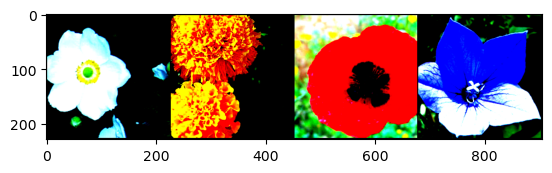

In [73]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net.eval()
with torch.no_grad():
    outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predict: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [74]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print('Accuracy of the network on the 1020 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1020 test images: 66 %


In [75]:
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))
preds = np.zeros((1))
truth = np.zeros((1))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(batch_size):
            if len(labels) <= i:
                continue
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# remove first element that is zero
preds = preds[1:]
truth = truth[1:]

for i in range(102):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     1 : 50 %
Accuracy of     2 : 100 %
Accuracy of     3 : 20 %
Accuracy of     4 : 40 %
Accuracy of     5 : 80 %
Accuracy of     6 : 40 %
Accuracy of     7 : 50 %
Accuracy of     8 : 90 %
Accuracy of     9 : 40 %
Accuracy of    10 : 70 %
Accuracy of    11 : 30 %
Accuracy of    12 : 80 %
Accuracy of    13 : 60 %
Accuracy of    14 : 60 %
Accuracy of    15 : 90 %
Accuracy of    16 : 40 %
Accuracy of    17 : 90 %
Accuracy of    18 : 50 %
Accuracy of    19 : 10 %
Accuracy of    20 : 30 %
Accuracy of    21 : 100 %
Accuracy of    22 : 60 %
Accuracy of    23 : 100 %
Accuracy of    24 : 100 %
Accuracy of    25 : 60 %
Accuracy of    26 : 60 %
Accuracy of    27 : 80 %
Accuracy of    28 : 60 %
Accuracy of    29 : 100 %
Accuracy of    30 : 70 %
Accuracy of    31 : 30 %
Accuracy of    32 : 10 %
Accuracy of    33 : 40 %
Accuracy of    34 : 50 %
Accuracy of    35 : 70 %
Accuracy of    36 : 70 %
Accuracy of    37 : 100 %
Accuracy of    38 : 20 %
Accuracy of    39 : 10 %
Accuracy of    40 :

Text(158.22222222222223, 0.5, 'label (ground truth)')

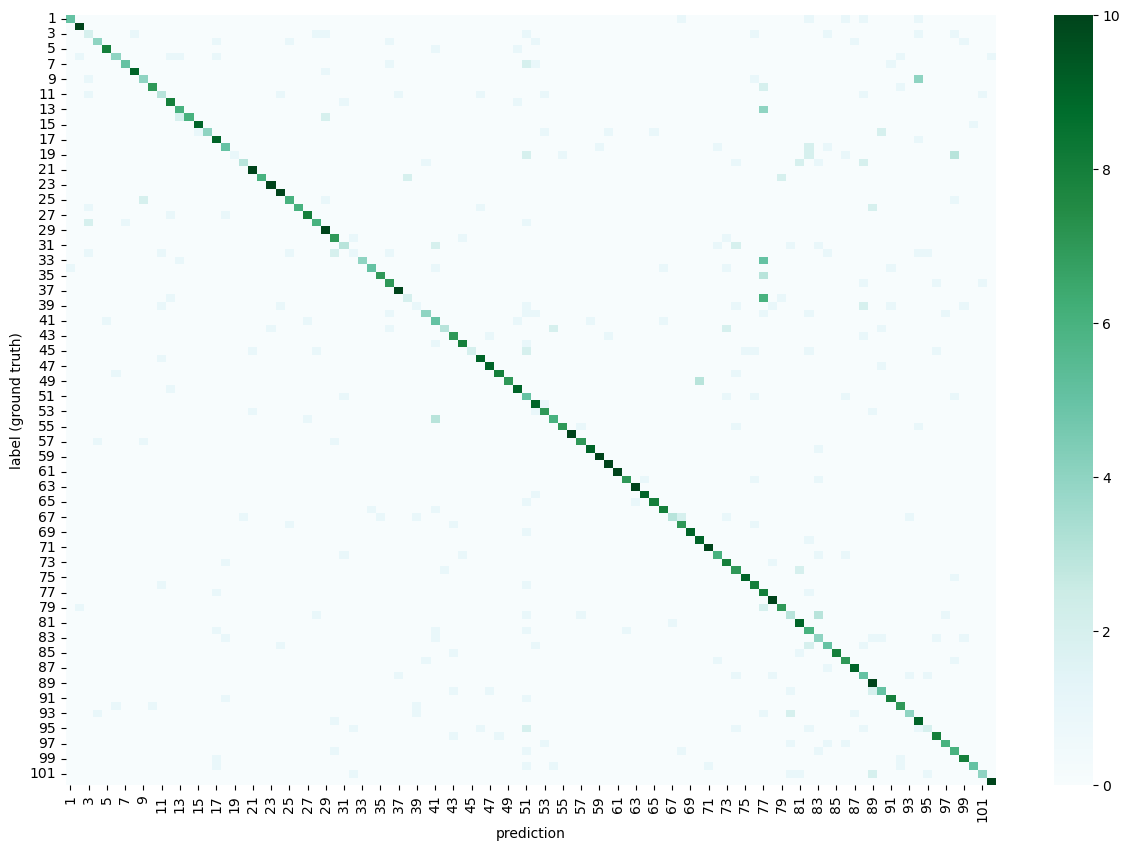

In [76]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names =  classes
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (15,10))
sns.heatmap(df_cm, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

In [77]:
statics = classification_report(truth, preds, target_names=class_names)
print(statics)

              precision    recall  f1-score   support

           1       0.83      0.50      0.62        10
           2       0.83      1.00      0.91        10
           3       0.25      0.20      0.22        10
           4       0.67      0.40      0.50        10
           5       0.89      0.80      0.84        10
           6       0.67      0.40      0.50        10
           7       0.83      0.50      0.62        10
           8       0.90      0.90      0.90        10
           9       0.57      0.40      0.47        10
          10       0.88      0.70      0.78        10
          11       0.43      0.30      0.35        10
          12       0.67      0.80      0.73        10
          13       0.60      0.60      0.60        10
          14       1.00      0.60      0.75        10
          15       0.90      0.90      0.90        10
          16       1.00      0.40      0.57        10
          17       0.60      0.90      0.72        10
          18       0.56    

In [78]:
df = pd.DataFrame(classification_report(truth, preds, target_names=class_names, output_dict=True)).transpose()
df

,precision,recall,f1-score,support
1,0.833333,0.500000,0.625000,10.000000
2,0.833333,1.000000,0.909091,10.000000
3,0.250000,0.200000,0.222222,10.000000
4,0.666667,0.400000,0.500000,10.000000
5,0.888889,0.800000,0.842105,10.000000
...,...,...,...,...
101,0.666667,0.400000,0.500000,10.000000
102,0.909091,1.000000,0.952381,10.000000
accuracy,0.669608,0.669608,0.669608,0.669608
macro avg,0.708112,0.669608,0.662007,1020.000000


In [79]:
def plot_bar(colum_name='recall'):
    df_tmp = df[:102]
    plt.figure(figsize=(18, 2))
    plt.title(f"{colum_name} < 0.7: {sum(df_tmp[colum_name] < 0.7)}")
    plt.plot(np.arange(len(df_tmp[colum_name])), 0.7*np.ones(len(df_tmp[colum_name])), c="r")
    plt.xticks(np.arange(0, 102, 5))
    plt.bar(np.arange(len(df_tmp[colum_name])), df_tmp[colum_name])
    plt.show()

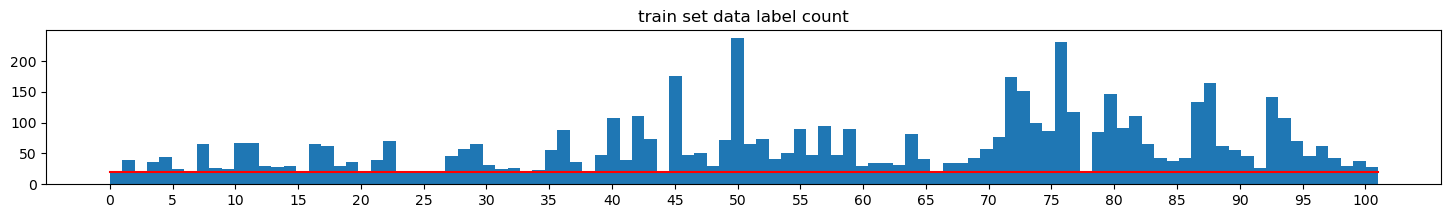

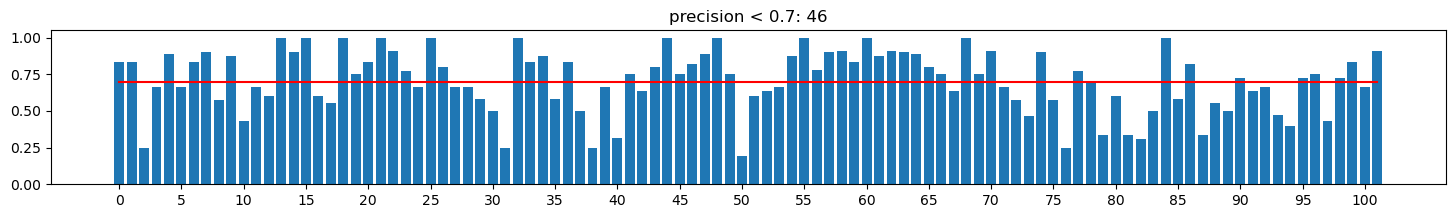

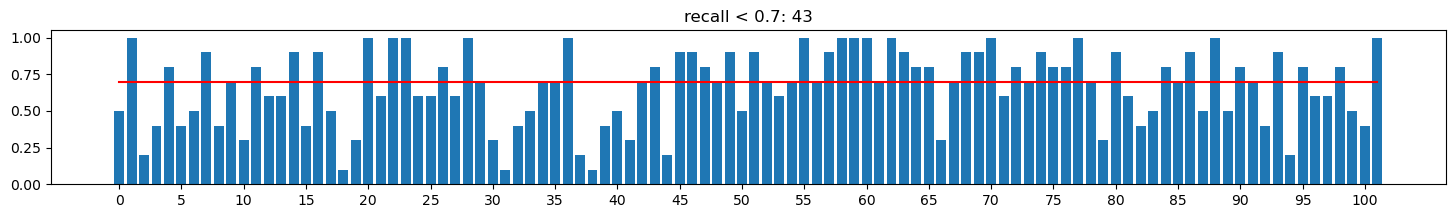

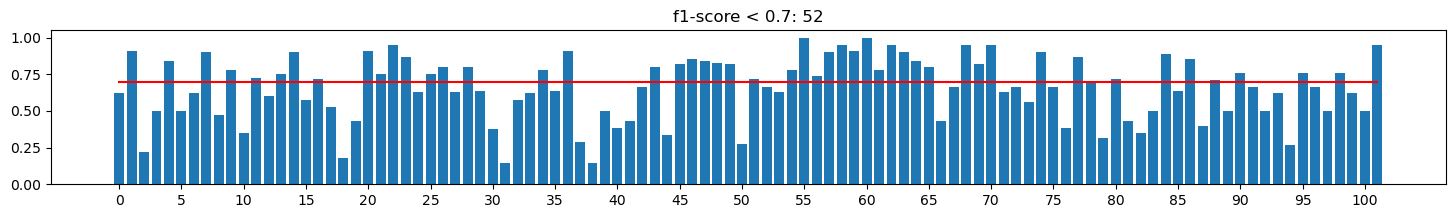

In [80]:
plt.figure(figsize=(18, 2))
plt.title("train set data label count")
plt.plot(np.arange(102), 20*np.ones(102), 'red')
plt.hist(train._labels, bins=102)
plt.xticks(np.arange(0, 102, 5))
plt.show()

for col in df.columns[:-1]:
    plot_bar(col)

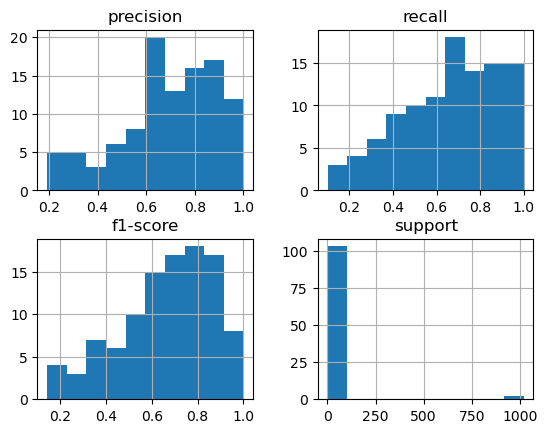

In [81]:
df.hist()
plt.show()